### Дилемма смещения и разброса. Полиномиальные признаки. Регуляризация

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing # полиномиальные признаки
%matplotlib inline
plt.style.use('seaborn-v0_8')

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']

Разделим дата-сет на тренировочную и тестовую выборки в соотношении 70/30

In [2]:
# инициализируем функцию по разделению дата сета на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split #as tts

# Делим выборку 70/30 и установим рандом - 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# вернем результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Train:', X_test.shape, y_test.shape)

Train: (354, 13) (354,)
Train: (152, 13) (152,)


Обучим линейную регрессию (с помощью МНК) на тренировочных данных и рассчитаем $R^2$ для тренировочных и тестовых данных

In [3]:
# создаем объект класса LinearRegression
lr_model = linear_model.LinearRegression()
# обучаем модель МНК
lr_model.fit(X_train, y_train)

# делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
# делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)

# рассчитываем коэфф. детерминации R2
print('R2 score: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))

R2 score: 0.743
R2 score: 0.722


На тренировочной выборке и $R^2$ на тестовой выборке. То есть показатели довольно близки друг к другу (низкий разброс ответов модели для разных выборок). Модель не переучена - no variance

### Регуляризация L1 и L2

In [4]:
# стандартизируем даные
scaler=preprocessing.StandardScaler()

# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)

#производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)

# производим стнадартизацию тестовой выборке с таким же параметрами, что и на тренировочной
X_test_scaled = scaler.transform(X_test)

# создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
# генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(354, 104)
(152, 104)


#### В sklearn методы регуляризации реализованы в классах:
#### Lasso (L1-регуляризация) и Ridge (L2-регуляризация).
Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.
<br>Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [5]:
# модель линейной регрессии с L1-регуляризацией

# создаём объект класса линейной регрессии L1-регуляризация
lasso_lr_poly = linear_model.Lasso(alpha=0.1)

# обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# предсказания для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)

# предсказания для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

# рассчитываем коэфф детерминации R2 для двух выборок
print('R2 score: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict_poly)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict_poly)))

R2 score: 0.879
R2 score: 0.882


Обратите внимание на то, как изменились значения метрик. Да, на тренировочной выборке $R^2 = 0.879$. Метрика упала (до стандартизации + регуляризации значение $R^2$ было $0.929$).
<br>Однако метрика ощутимо выросла на тестовой выборке: $R^2$ = $0.882$ (ранее она была равна $0.268$).
<br>Мы смогли преодолеть переобучение.

In [6]:
# выведем значения коэфф модели, округлив их о третьего знака
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


Большая часть коэффициентов обнулилась. Это значит, что признаки, которые соответствуют этим коэффициентам, не используются в прогнозе модели Lasso-регрессии.

In [9]:
# создаем класс линейной регресси L2-регуляризации
ridge_lr_poly = linear_model.Ridge(alpha=10)

# обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)

# предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

# рассчитываем коэфф детерминации R2 для двух выборок
print('R2 score: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict_poly)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict_poly)))

R2 score: 0.907
R2 score: 0.848


Значения метрики $R^2$ на тестовой выборке для L1-регуляризации получились немного выше. В первую очередь мы всегда ориентируемся на тестовую выборку — это данные, которые модель ещё не видела.

In [10]:
# выведем значения коэфф модели, округлив их о третьего знака
print(np.round(ridge_lr_poly.coef_, 3))

[ 0.128 -0.049  0.084  0.117 -0.932  2.848 -1.008 -1.464  0.909 -0.908
 -0.653  0.971 -2.605  0.085 -0.032  0.466  2.721 -0.507  0.986  0.309
 -0.391 -0.714  0.376 -0.379  0.072  0.287  0.143 -0.138 -0.014  0.315
  0.05  -0.409 -0.316  0.075  0.702  0.08  -0.281 -0.37   0.511  0.175
  0.72   0.282  0.477  0.888 -0.012  0.074 -0.052  0.166 -0.263  0.414
 -1.129 -0.852  0.273  0.227 -0.106  0.368 -0.137 -0.241 -0.697 -0.177
 -0.326 -0.524  0.882 -0.637  0.344 -0.439 -0.006  0.386  0.233 -0.535
  0.111 -0.802 -0.662 -0.56   0.22  -1.001  0.123  0.144  0.889 -0.114
 -0.086 -1.022 -0.71   1.08  -0.446 -0.178 -0.07  -0.496  0.874 -0.926
  0.717  0.601 -0.49  -0.723  0.308  1.086 -0.448 -1.256  0.057  0.354
 -0.059 -0.433 -0.791  0.177]


Видно, что L2-регуляризация не обнуляет коэффициенты — она использует для предсказания все признаки.

Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции $linspace()$ из библиотеки numpy.
<https://pyprog.pro/array_creation/linspace.html>

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики $R^2$ на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores

In [13]:
# создаем список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
# создадим два пустых списка, в которые будем добавлять результаты
train_score = []
test_score = []

# с помощью цикла обучаем модель на 20 разныз значениях alpha и заполняем пустые списки
for i in alpha_list:
    # создаём объект класса линейной регрессии L1-регуляризация
    lasso_lr_poly = linear_model.Lasso(alpha=i, max_iter=10000)
    # обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    # предсказания для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    # предсказания для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    
    # рассчитываем коэфф R2 и добавляем их в списки
    train_score.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_score.append(metrics.r2_score(y_test, y_test_predict_poly))

В результате выполнения данного кода в списках train_scores и test_scores появятся 20 различных значений $R^2$ на тренировочной и тестовой выборках.

Давайте построим линейные графики, которые покажут, как меняется метрика $R^2$ на тренировочной и тестовой выборках в зависимости от alpha:

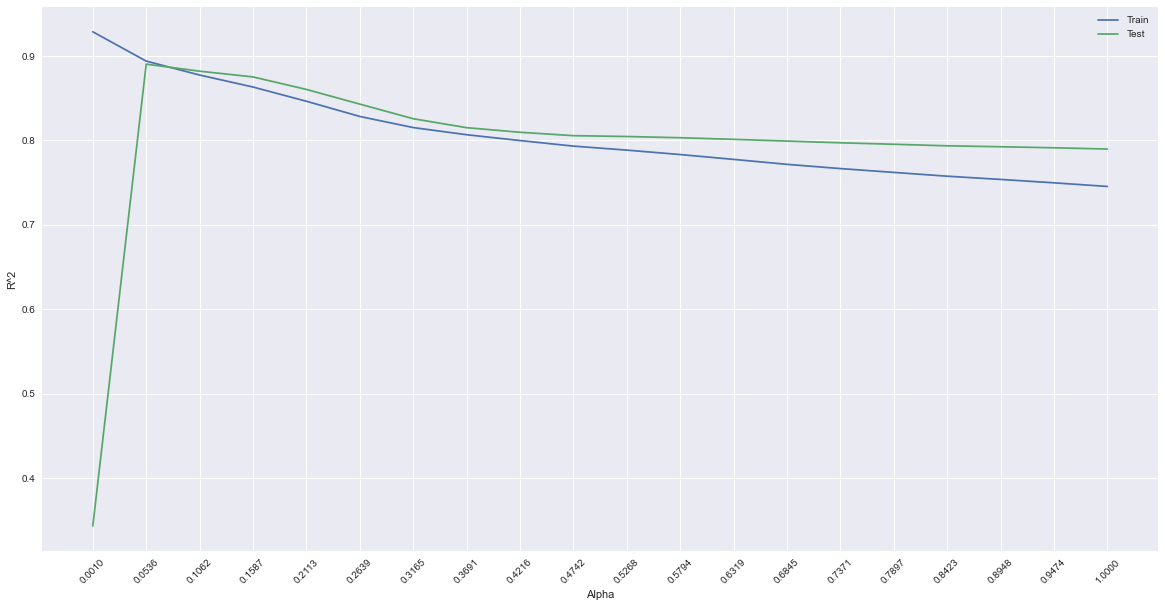

In [28]:
# визуализируем R2 от alpha
fig, ax = plt.subplots(figsize=(20, 10)) #создаем фигуру + координатную плоскость
ax.plot(alpha_list, train_score, label='Train') # линейный график для тренировочной выборки
ax.plot(alpha_list, test_score, label='Test') # линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') # название оси ординат
ax.set_xticks(alpha_list) # метка оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); # отображение легенды

С помощью графика мы можем подобрать оптимальное значение параметра $alpha$. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.

Видно, что $R^2$ на тестовой выборке достигает наибольшего значения в точке $0.0536$. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.

Обратите внимание, что на тренировочной выборке $R^2$ непрерывно падает с ростом $alpha$. Оно и понятно, ведь чем больше $alpha$, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.

In [57]:
# подставим значение alpha=0.0536 в модель Lasso и получим результат
# создаём объект класса линейной регрессии L1-регуляризация
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)

# обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# предсказания для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)

# предсказания для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

# рассчитываем коэфф детерминации R2 для двух выборок
print('R^2 score Train: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict_poly)))
print('R^2 score Test: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict_poly)))

R^2 score Train: 0.894
R^2 score Test: 0.890


 Метрика $R^2$ выросла благодаря тому, что мы смогли подобрать оптимальное значение параметра $alpha$.